In [1]:
# including the project directory to the notebook level
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#importing modules

#modules for data reading and parsing dates
from dataprocess import dataprocessor as dp

# Get the raw VRF data from csv files

In [16]:
# load data path
vrfdata = dp.readfolder('../data/raw/VRF_setpoint/',
                        timeformat='%Y-%m-%d %H:%M:%S',
                        dateheading='Date')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['files2dflist', 'datetime_parse_dflist', 'merge_dflist']
vrf = vrfdata.return_df(processmethods=processmethods)

Finished 'dataframeplot' in 3.4290 secs


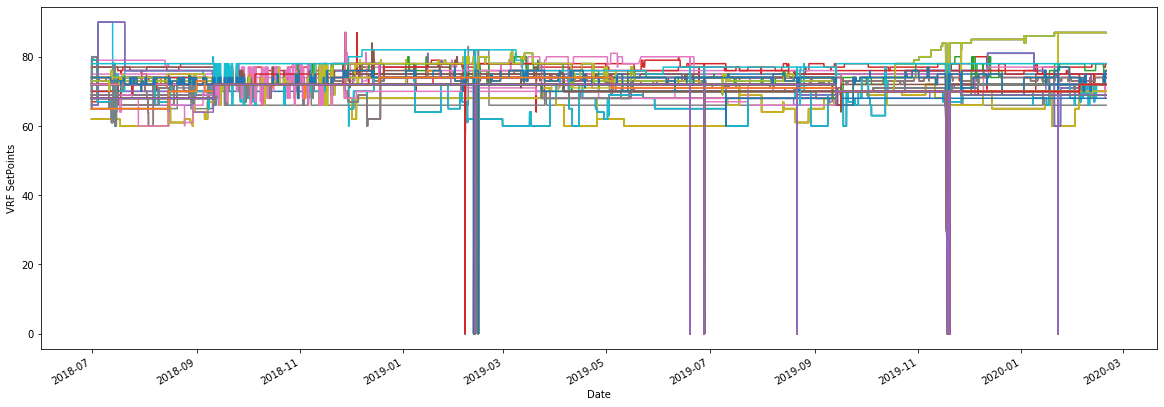

In [18]:
# Drop Columns where >5% of values are missing
vrf = dp.dropNaNcols(vrf, threshold=0.95)

# Drop columns of constant values if needed
vrf = dp.constantvaluecols(vrf, limit=0.2)

# Plot the df
dp.dataframeplot(vrf, ylabel='VRF SetPoints', xlabel='Date', style='-')

### This data has collective outliers. So we remove them based on bounds


Retaining 97.79391149946264% of the data
Finished 'removeoutliers' in 12.9826 secs
Finished 'dataframeplot' in 3.1818 secs


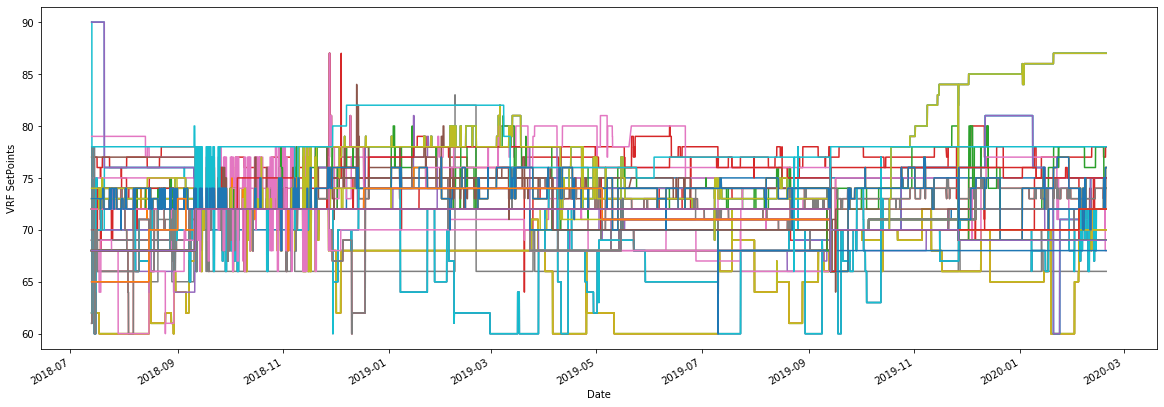

In [19]:
# remove outliers based on bounds
vrf = dp.removeoutliers(vrf,
                        columns=vrf.columns,
                        upperbound=100,
                        lowerbound=40)

# Plot the df
dp.dataframeplot(vrf, ylabel='VRF SetPoints', xlabel='Date', style='-')

In [20]:
# saving the data
vrf.to_pickle('../data/processed/vrf.pkl')

# Get the raw Alumni AHU data from CSV files

In [6]:
# load data path
ahudata = dp.readfile('../data/raw/energyvars/File1.csv',
                      timeformat='%Y-%m-%d %H:%M:%S+00:00',
                      dateheading='time')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
ahu = ahudata.return_df(processmethods=processmethods)

In [7]:
# drop cooling tower humidity infos as they contain constant values which seem unreliable
ahu = ahu.drop(
    columns=['Chiller_1 outdoorAirHumidity', 'CT_2 outdoorAirHumidity'])

# Drop Columns where >5% of values are NaN
ahu = dp.dropNaNcols(ahu, threshold=0.95)

# Drop rows with NaN
ahu = dp.dropNaNrows(ahu)

Finished 'dataframeplot' in 0.5895 secs


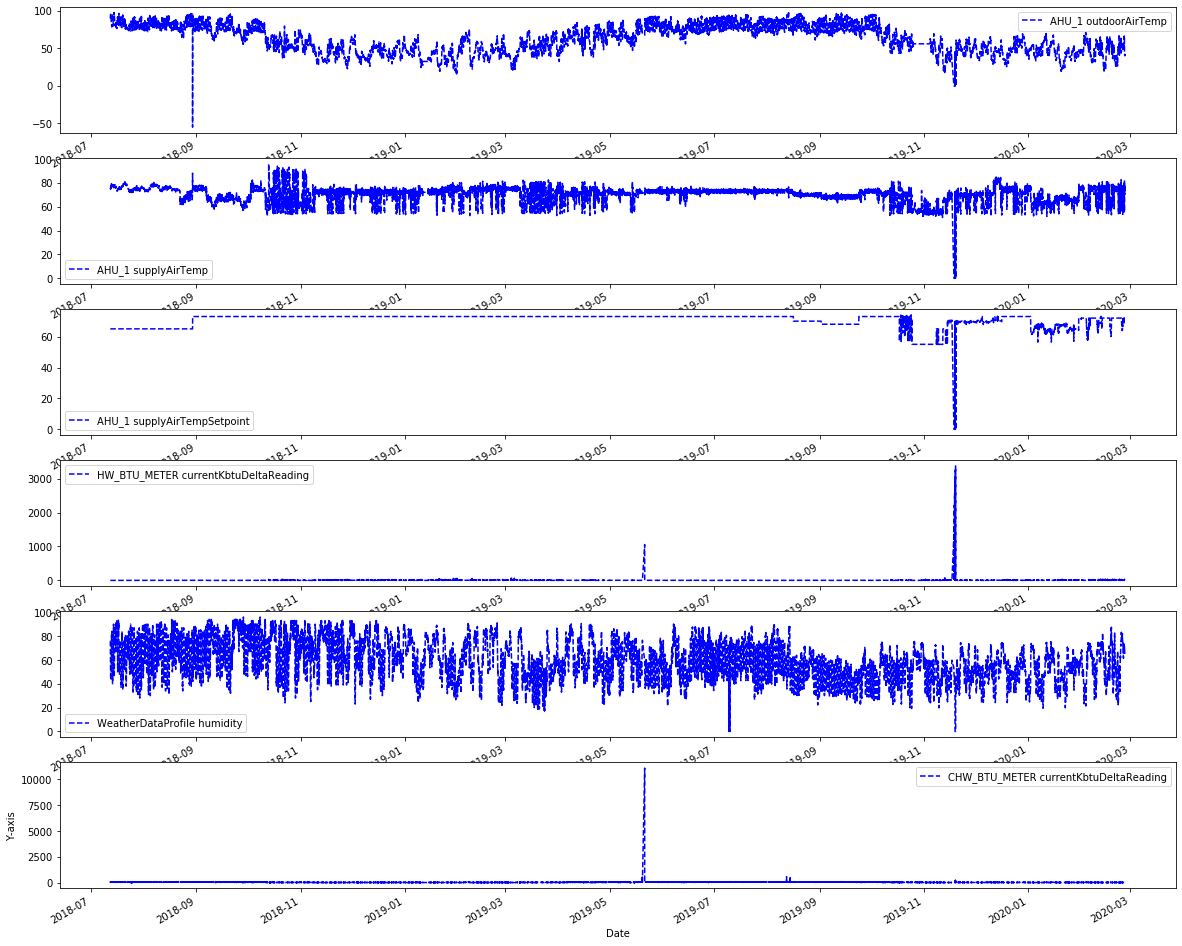

In [8]:
# Plot the df
dp.dataframeplot(ahu, xlabel='Date', lazy=False, legend=True)

### Some data incorporate both statistical outliers and collective point outliers. We have to first remove the collective point outliers to perform meaningful statistical outlier based removal

In [9]:
# remove outleirs based on bounds
# 1 remove on hw energy bounds
# 2 remove on chw energy bounds
# 3 remove on setpoint bounds
# 4 remove on supply air temperature
# 5  remove on outside air temeprature
name = ['AHU_1 supplyAirTempSetpoint', 'HW_BTU_METER currentKbtuDeltaReading',\
        'CHW_BTU_METER currentKbtuDeltaReading', 'AHU_1 supplyAirTemp', 'AHU_1 outdoorAirTemp']
u_bound = [90, 500, 100, 90, 120]
l_bound = [40, -1, -1, 40, -10]
for i in range(len(name)):
    ahu = dp.removeoutliers(ahu,
                            columns=[name[i]],
                            upperbound=u_bound[i],
                            lowerbound=l_bound[i])


Retaining 99.8486793297142% of the data
Finished 'removeoutliers' in 8.2912 secs



Retaining 99.99764124518667% of the data
Finished 'removeoutliers' in 8.2999 secs



Retaining 99.99528237909622% of the data
Finished 'removeoutliers' in 8.5352 secs



Retaining 99.94987291309143% of the data
Finished 'removeoutliers' in 8.4044 secs



Retaining 99.99763989521135% of the data
Finished 'removeoutliers' in 8.3950 secs


In [10]:
# remove outliers based on z-thresh
col_list = [
    'AHU_1 outdoorAirTemp', 'AHU_1 supplyAirTemp',
    'WeatherDataProfile humidity', 'HW_BTU_METER currentKbtuDeltaReading'
]
ahu = dp.removeoutliers(ahu, columns=col_list, z_thresh=3)

Retaining 98.16792541892849% of the data
Finished 'removeoutliers' in 0.6158 secs


Finished 'dataframeplot' in 0.4889 secs


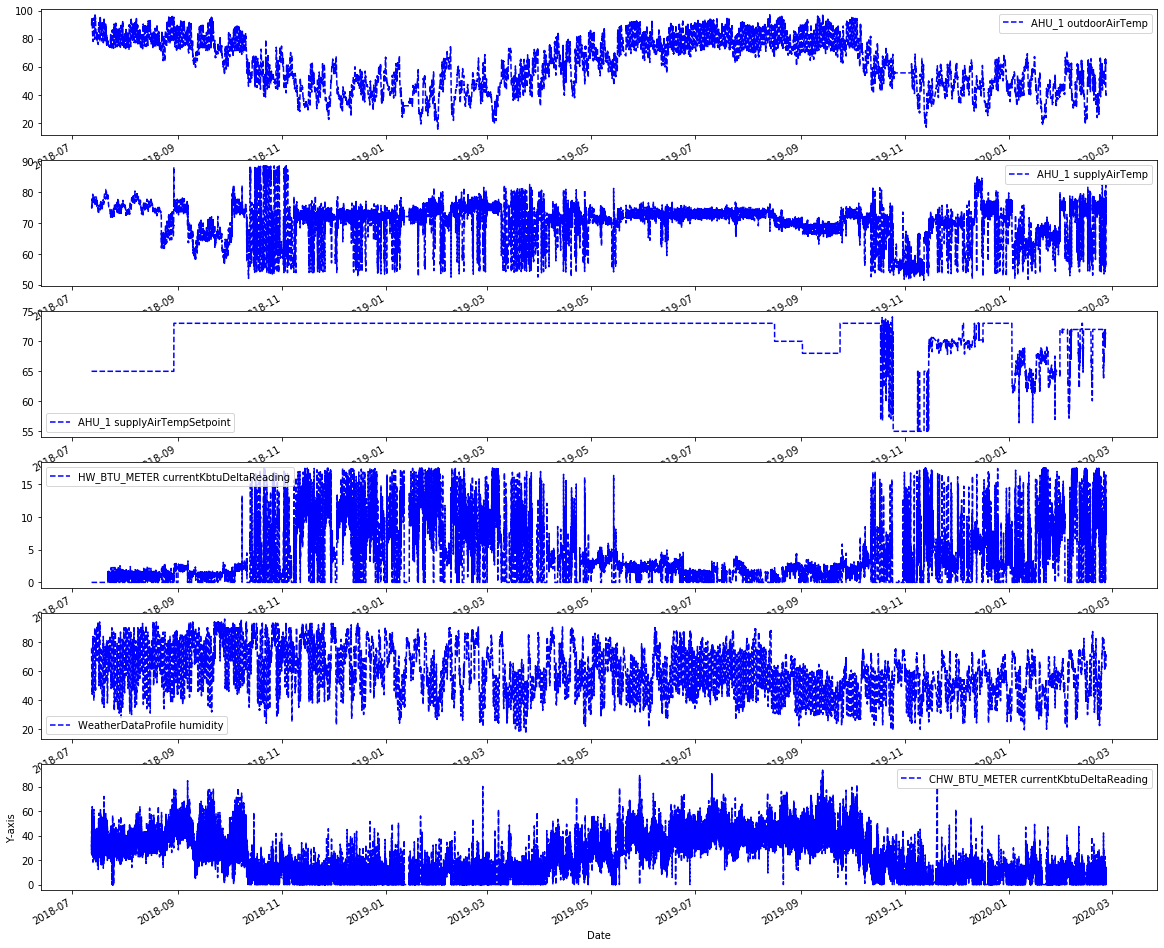

In [11]:
# Plot the df
dp.dataframeplot(ahu, xlabel='Date', lazy=False, legend=True)

In [ ]:
# rearange cols for later use
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'AHU_1 supplyAirTemp',
    'AHU_1 supplyAirTempSetpoint', 'WeatherDataProfile humidity',
    'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# save the data in pickeld format
ahu.to_pickle('../data/processed/ahu1energy.pkl')

# Get raw solar GHI information

In [3]:
# get old solar irradiation data from july 12th 2018 to Oct 23rd 2019

# load data path
olddata = dp.readfile('../data/raw/solardata/RL_relearn_data_v2.pkl')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df']
olddf = olddata.return_df(processmethods=processmethods)

# We need only ghi data
olddf = olddf[['Ghi']]

In [5]:
# get new Solar irradiation data from Oct 23rd 2019 to present data

# load data path
newdata = dp.readfile('../data/raw/solardata/Nashville_Solcast_PT5M.csv',
                     dateheading="PeriodEnd", timeformat='%Y-%m-%dT%H:%M:%SZ')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
newdf = newdata.return_df(processmethods=processmethods)

# Since it still contains many redundant cols we retain only Ghi
newdf = newdf[['Ghi']]

In [6]:
# merge old and new solar irradiation data
ghidf = dp.mergerows([olddf, newdf])

In [11]:
ghidf.head()

,Ghi
2018-07-12 08:55:00,745.0
2018-07-12 09:00:00,758.0
2018-07-12 09:05:00,772.0
2018-07-12 09:10:00,785.0
2018-07-12 09:15:00,798.0


In [13]:
# removing statistical outliers if any
# remove outliers based on z-thresh
col_list = ['Ghi']
ghidf = dp.removeoutliers(ghidf, columns=col_list, z_thresh=3)

Retaining 98.95114006514657% of the data
Finished 'removeoutliers' in 0.0153 secs


Finished 'dataframeplot' in 0.1027 secs


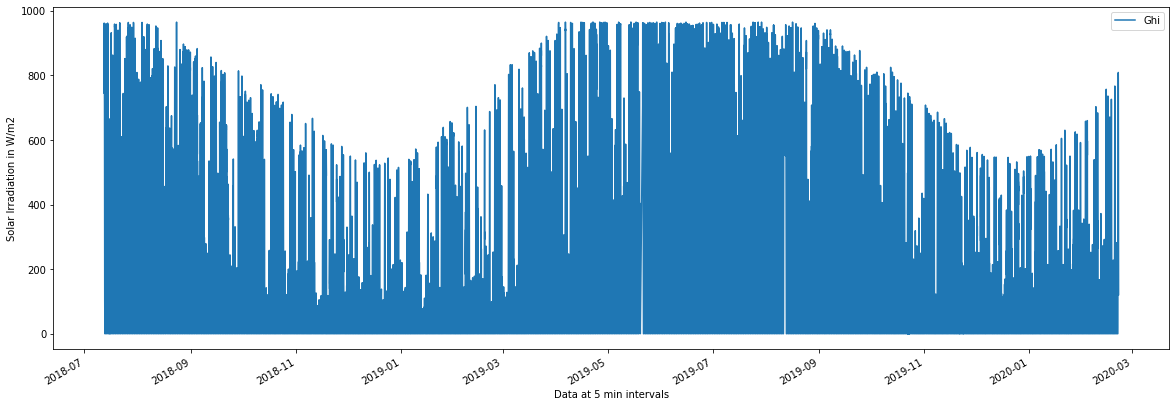

In [14]:
dp.dataframeplot(df=ghidf,
                 style='-',
                 xlabel='Data at 5 min intervals',
                ylabel='Solar Irradiation in W/m2',
                legend=True)

In [15]:
# Saving the processed data
ghidf.to_pickle('../data/processed/ghi.pkl')